In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

import plotly.subplots as sp
import plotly.graph_objects as go
import numpy as np

In [ ]:
# def visualize_feature_maps(feature_maps, title):
#     num_feature_maps = feature_maps.shape[1]
#     fig, axs = plt.subplots(1, num_feature_maps, figsize=(20, 20))
#     for i in range(min(5, num_feature_maps)):
#         axs[i].imshow(feature_maps[0, i].detach().numpy(), cmap='gray')
#         axs[i].axis('off')
#     plt.suptitle(title)
#     plt.show()



def visualize_feature_maps(feature_maps, title):
    num_feature_maps = feature_maps.shape[1]
    grid_size = int(np.ceil(np.sqrt(num_feature_maps)))

    fig, axs = plt.subplots(grid_size, grid_size, figsize=(20, 20))
    for i in range(min(num_feature_maps, grid_size * grid_size)):
        row = i // grid_size
        col = i % grid_size
        feature_map = feature_maps[0, i].detach().numpy()
        axs[row, col].imshow(feature_map, cmap='viridis')  # No grayscale conversion
        axs[row, col].axis('off')

    for i in range(num_feature_maps, grid_size * grid_size):
        axs[i // grid_size, i % grid_size].axis('off')

    plt.suptitle(title)
    plt.show()

In [ ]:
def visualize_feature_maps2(feature_maps, title):
    num_feature_maps = feature_maps.shape[1]

    grid_size = int(np.ceil(np.sqrt(num_feature_maps)))

    fig, axs = plt.subplots(grid_size, grid_size, figsize=(20, 20))

    for i in range(num_feature_maps):
        row = i // grid_size
        col = i % grid_size
        axs[row, col].imshow(feature_maps[0, i].detach().numpy(), cmap='gray')
        axs[row, col].axis('off')

    for i in range(num_feature_maps, grid_size * grid_size):
        axs[i // grid_size, i % grid_size].axis('off')

    plt.suptitle(title)
    plt.show()

In [ ]:
def visualize_feature_maps_plotly(feature_maps, title):
    num_feature_maps = feature_maps.shape[1]
    grid_size = int(np.ceil(np.sqrt(num_feature_maps)))

    # Create a subplot grid with the necessary number of subplots
    fig = sp.make_subplots(rows=grid_size, cols=grid_size,
                           vertical_spacing=0.02, horizontal_spacing=0.02)

    # Loop through the feature maps and plot each one
    for i in range(min(num_feature_maps, grid_size * grid_size)):
        row = (i // grid_size) + 1
        col = (i % grid_size) + 1
        feature_map = feature_maps[0, i].detach().cpu().numpy()

        # Normalize the feature map to the range [0, 1] for better visualization
        feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min())

        # Add the feature map to the grid
        fig.add_trace(go.Heatmap(z=feature_map, colorscale='Viridis', showscale=False), row=row, col=col)

    # Hide any empty subplots if necessary
    for i in range(num_feature_maps, grid_size * grid_size):
        fig.update_xaxes(visible=False, row=(i // grid_size) + 1, col=(i % grid_size) + 1)
        fig.update_yaxes(visible=False, row=(i // grid_size) + 1, col=(i % grid_size) + 1)

    # Set the title
    fig.update_layout(title_text=title, height=800, width=800, showlegend=False)
    fig.show()

![](inception_arch.png)

In [ ]:
class InceptionModule(nn.Module):
    def __init__(self, input_channels):
        super(InceptionModule, self).__init__()

        self.conv1x1 = nn.Conv2d(input_channels, 16, kernel_size=1)
        self.conv3x3 = nn.Conv2d(input_channels, 24, kernel_size=3, padding=1)
        self.conv5x5 = nn.Conv2d(input_channels, 32, kernel_size=5, padding=2)

        # convolution after the max pooling
        self.maxpooled_conv1x1 = nn.Conv2d(input_channels, 8, kernel_size=1)

    def forward(self, x):
        out1 = self.conv1x1(x)
        out2 = self.conv3x3(x)
        out3 = self.conv5x5(x)

        # 3x3 max pooling
        out4 = F.max_pool2d(x, kernel_size=3, stride=1, padding=1)

        out4 = self.maxpooled_conv1x1(out4)

        return torch.cat([out1, out2, out3, out4], dim=1)


In [ ]:
img = torch.randn(32, 32,32, 3) #[batch_size x image_height x image_width x number_of_channels]
inception = InceptionModule(input_channels = img.shape[2])
print(inception)

print(f'Output of Inception Module is:')
result = inception.forward(img)
print(result.shape)

InceptionModule(
  (conv1x1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
  (conv3x3): Conv2d(32, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5x5): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpooled_conv1x1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
)
Output of Inception Module is:
torch.Size([32, 80, 32, 3])


In [ ]:
class AuxiliaryClassifier(nn.Module):
    def __init__(self, input_channels, num_classes=10):
        super(AuxiliaryClassifier, self).__init__()

        self.conv = nn.Conv2d(input_channels, 128, kernel_size=3, padding=1)
        self.fc = nn.Linear(128*4*4, num_classes)

    def forward(self, x):
        x = F.adaptive_avg_pool2d(x, (4,4))
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
img = torch.randn(32, 32,32, 3) #[batch_size x image_height x image_width x number_of_channels]
auxiliary_classifier = AuxiliaryClassifier(input_channels = img.shape[2])
print(auxiliary_classifier)

print(f'Output of auxiliary_classifier Module is:')
result = auxiliary_classifier.forward(img)
print(result.shape)

AuxiliaryClassifier(
  (conv): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc): Linear(in_features=2048, out_features=10, bias=True)
)
Output of auxiliary_classifier Module is:
torch.Size([32, 10])


## Making a simple model

* Including both inception module and auxiliary classifier

In [ ]:
class SimpleModel(nn.Module):
    def __init__(self, input_channels=3):
        super(SimpleModel, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3)
        self.inception = InceptionModule(64)
        self.aux_classifier = AuxiliaryClassifier(80)

    def forward(self, x):
        x = self.conv1(x)
        inception_output = self.inception(x)
        aux_output = self.aux_classifier(inception_output)
        return inception_output, aux_output

In [ ]:
img = torch.randn(32, 32,32, 3) #[batch_size x image_height x image_width x number_of_channels]
model = SimpleModel(input_channels = img.shape[2])
print(model)

print(f'Output of model is:')
result_inception, result_auxiliary = model.forward(img)
print(result_inception.shape, result_auxiliary.shape)

SimpleModel(
  (conv1): Conv2d(32, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (inception): InceptionModule(
    (conv1x1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
    (conv3x3): Conv2d(64, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5x5): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (maxpooled_conv1x1): Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1))
  )
  (aux_classifier): AuxiliaryClassifier(
    (conv): Conv2d(80, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fc): Linear(in_features=2048, out_features=10, bias=True)
  )
)
Output of model is:
torch.Size([32, 80, 16, 2]) torch.Size([32, 10])


## Visualizing the output

In [ ]:
# Dataset and Transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [ ]:
# dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

# stanford dogs dataset
dataset = datasets.CIFAR100(root='./data', download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

model = SimpleModel()

100%|██████████| 169001437/169001437 [00:02<00:00, 57548971.74it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data


In [97]:
images, labels = next(iter(data_loader))

inception_output, aux_output = model(images)
images.shape, labels.shape, inception_output.shape, aux_output.shape

(torch.Size([1, 3, 224, 224]),
 torch.Size([1]),
 torch.Size([1, 80, 112, 112]),
 torch.Size([1, 10]))

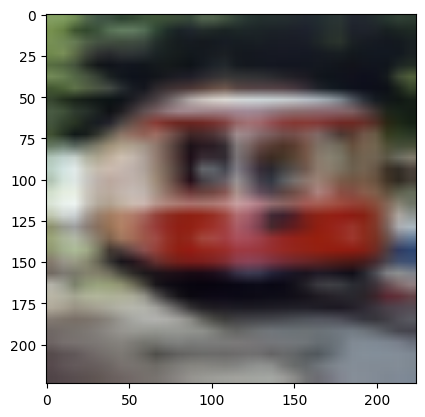

In [99]:
def imshow(img):
    # img = img / 2 + 0.5   # unnormalize
    npimg = img.numpy()   # convert from tensor
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(images[0])

Feature Maps After Initial Convolution:


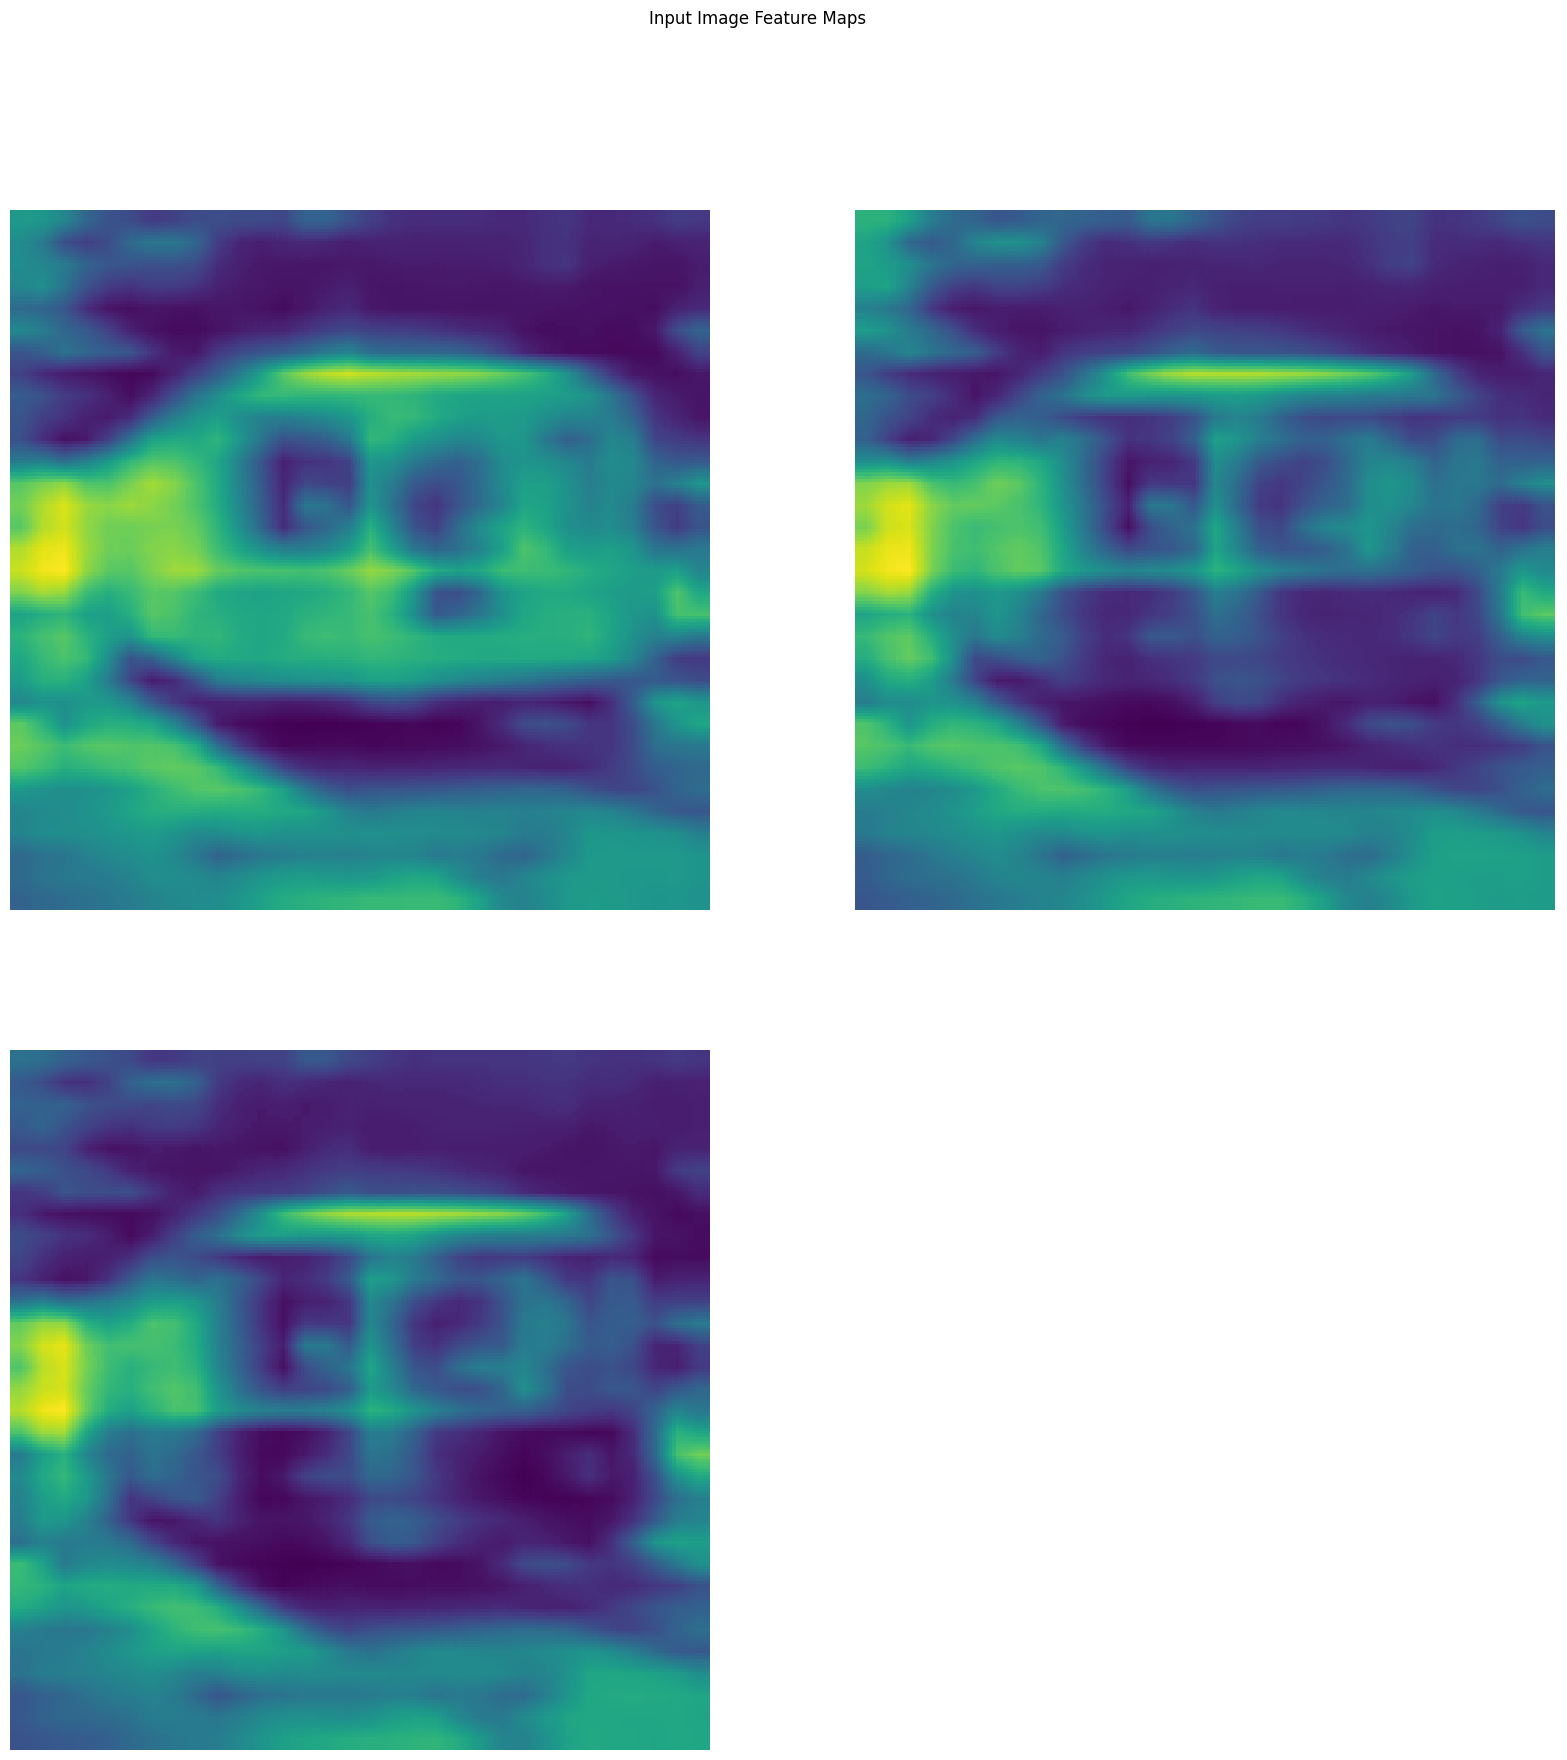

Feature Maps After Inception Module:


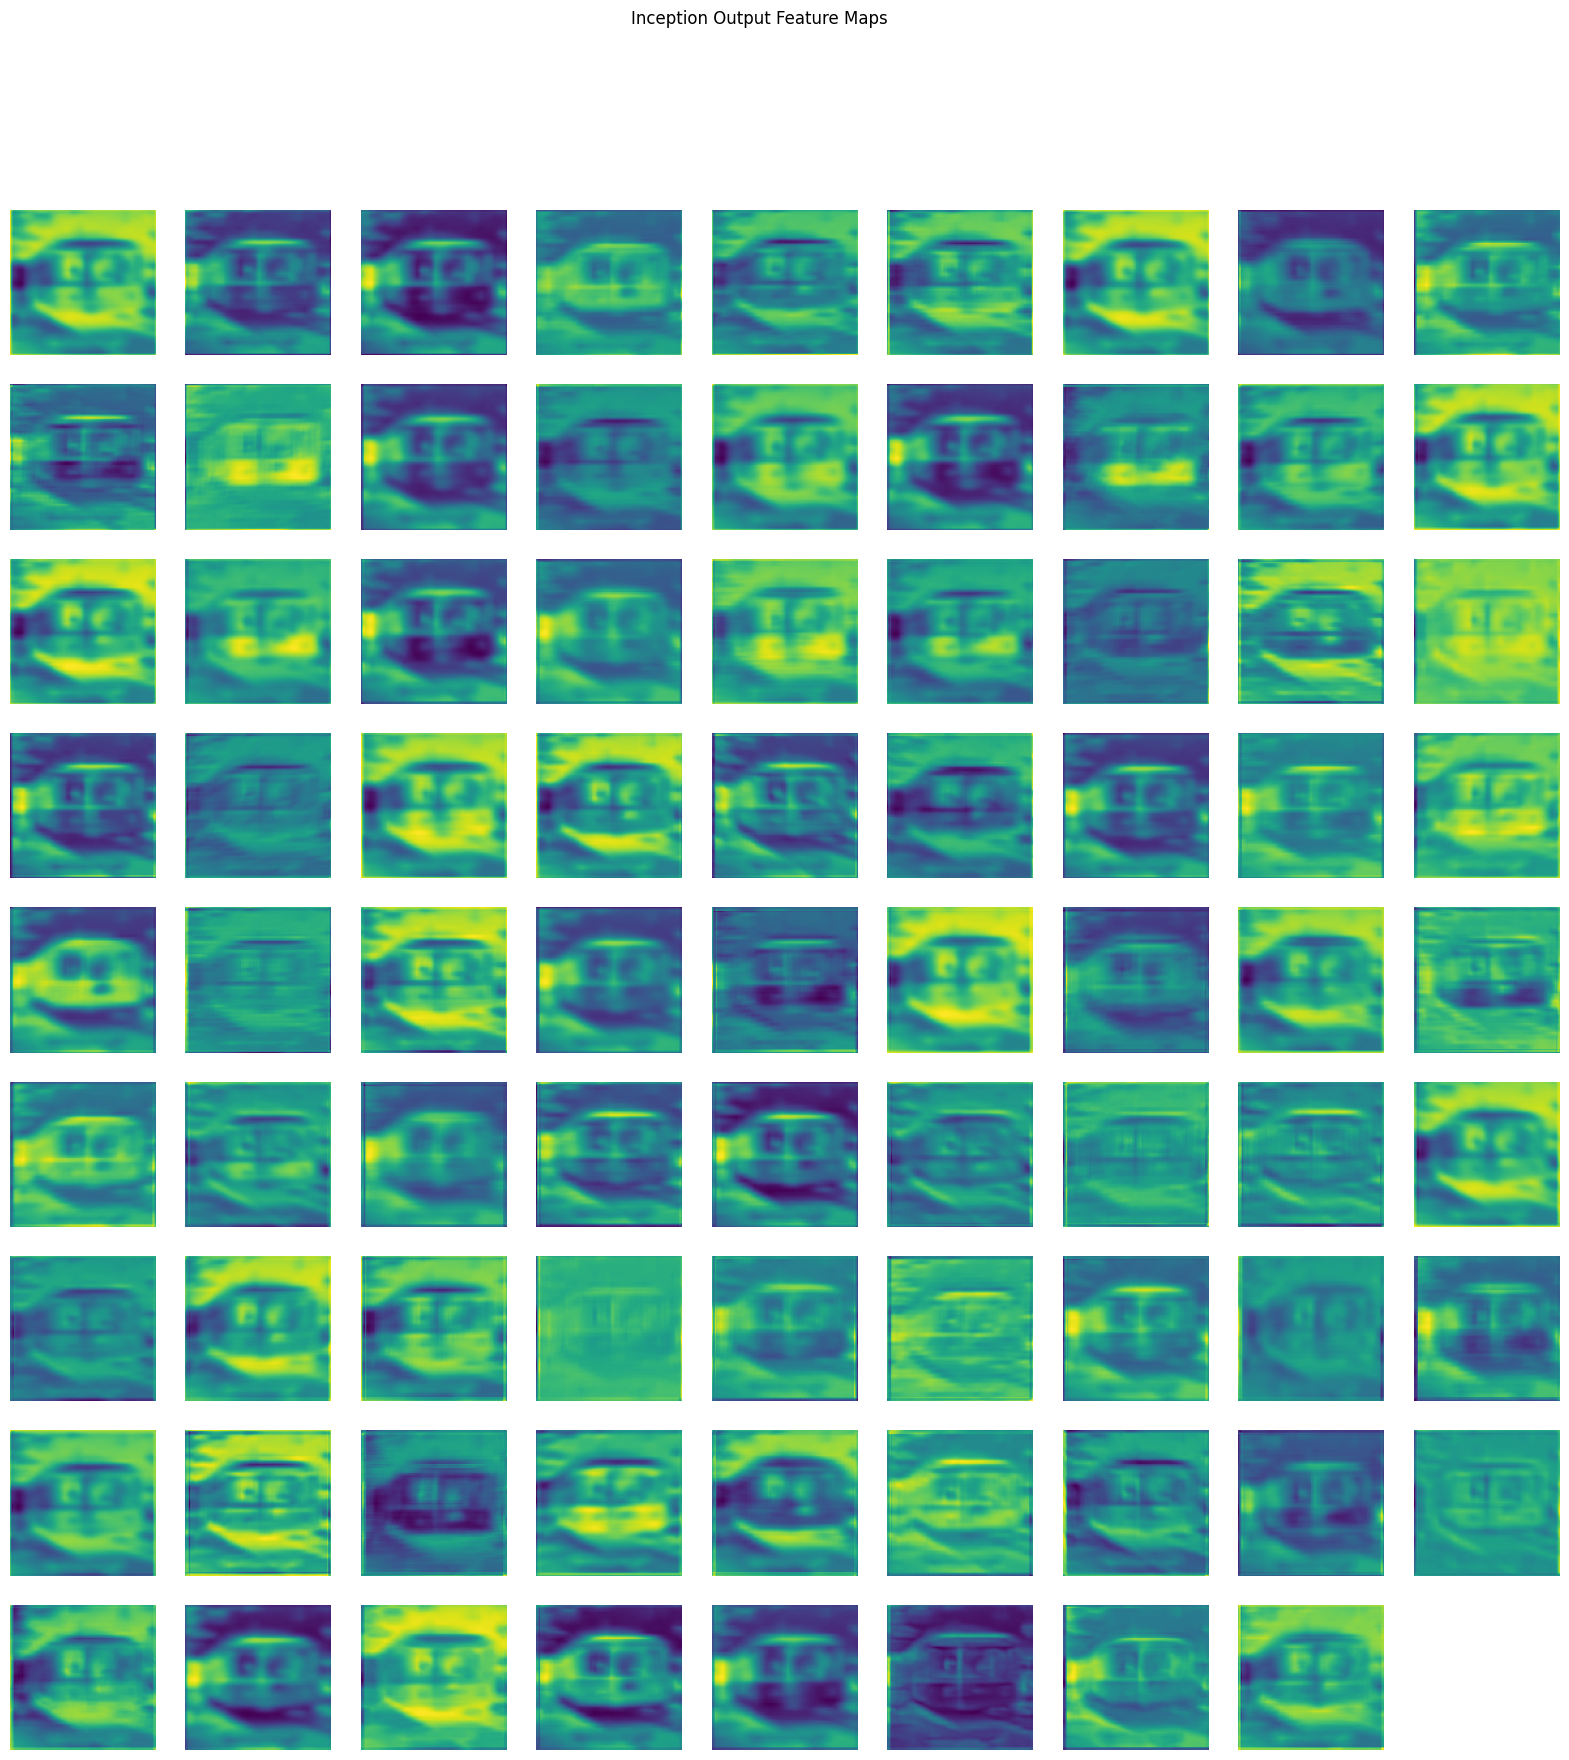

In [100]:
with torch.no_grad():
    print("Feature Maps After Initial Convolution:")
    visualize_feature_maps(images, title="Input Image Feature Maps")

    print("Feature Maps After Inception Module:")
    visualize_feature_maps(inception_output, title="Inception Output Feature Maps")

    # print("Auxiliary Classifier Output (Before Softmax):", aux_output)


Feature Maps After Initial Convolution:


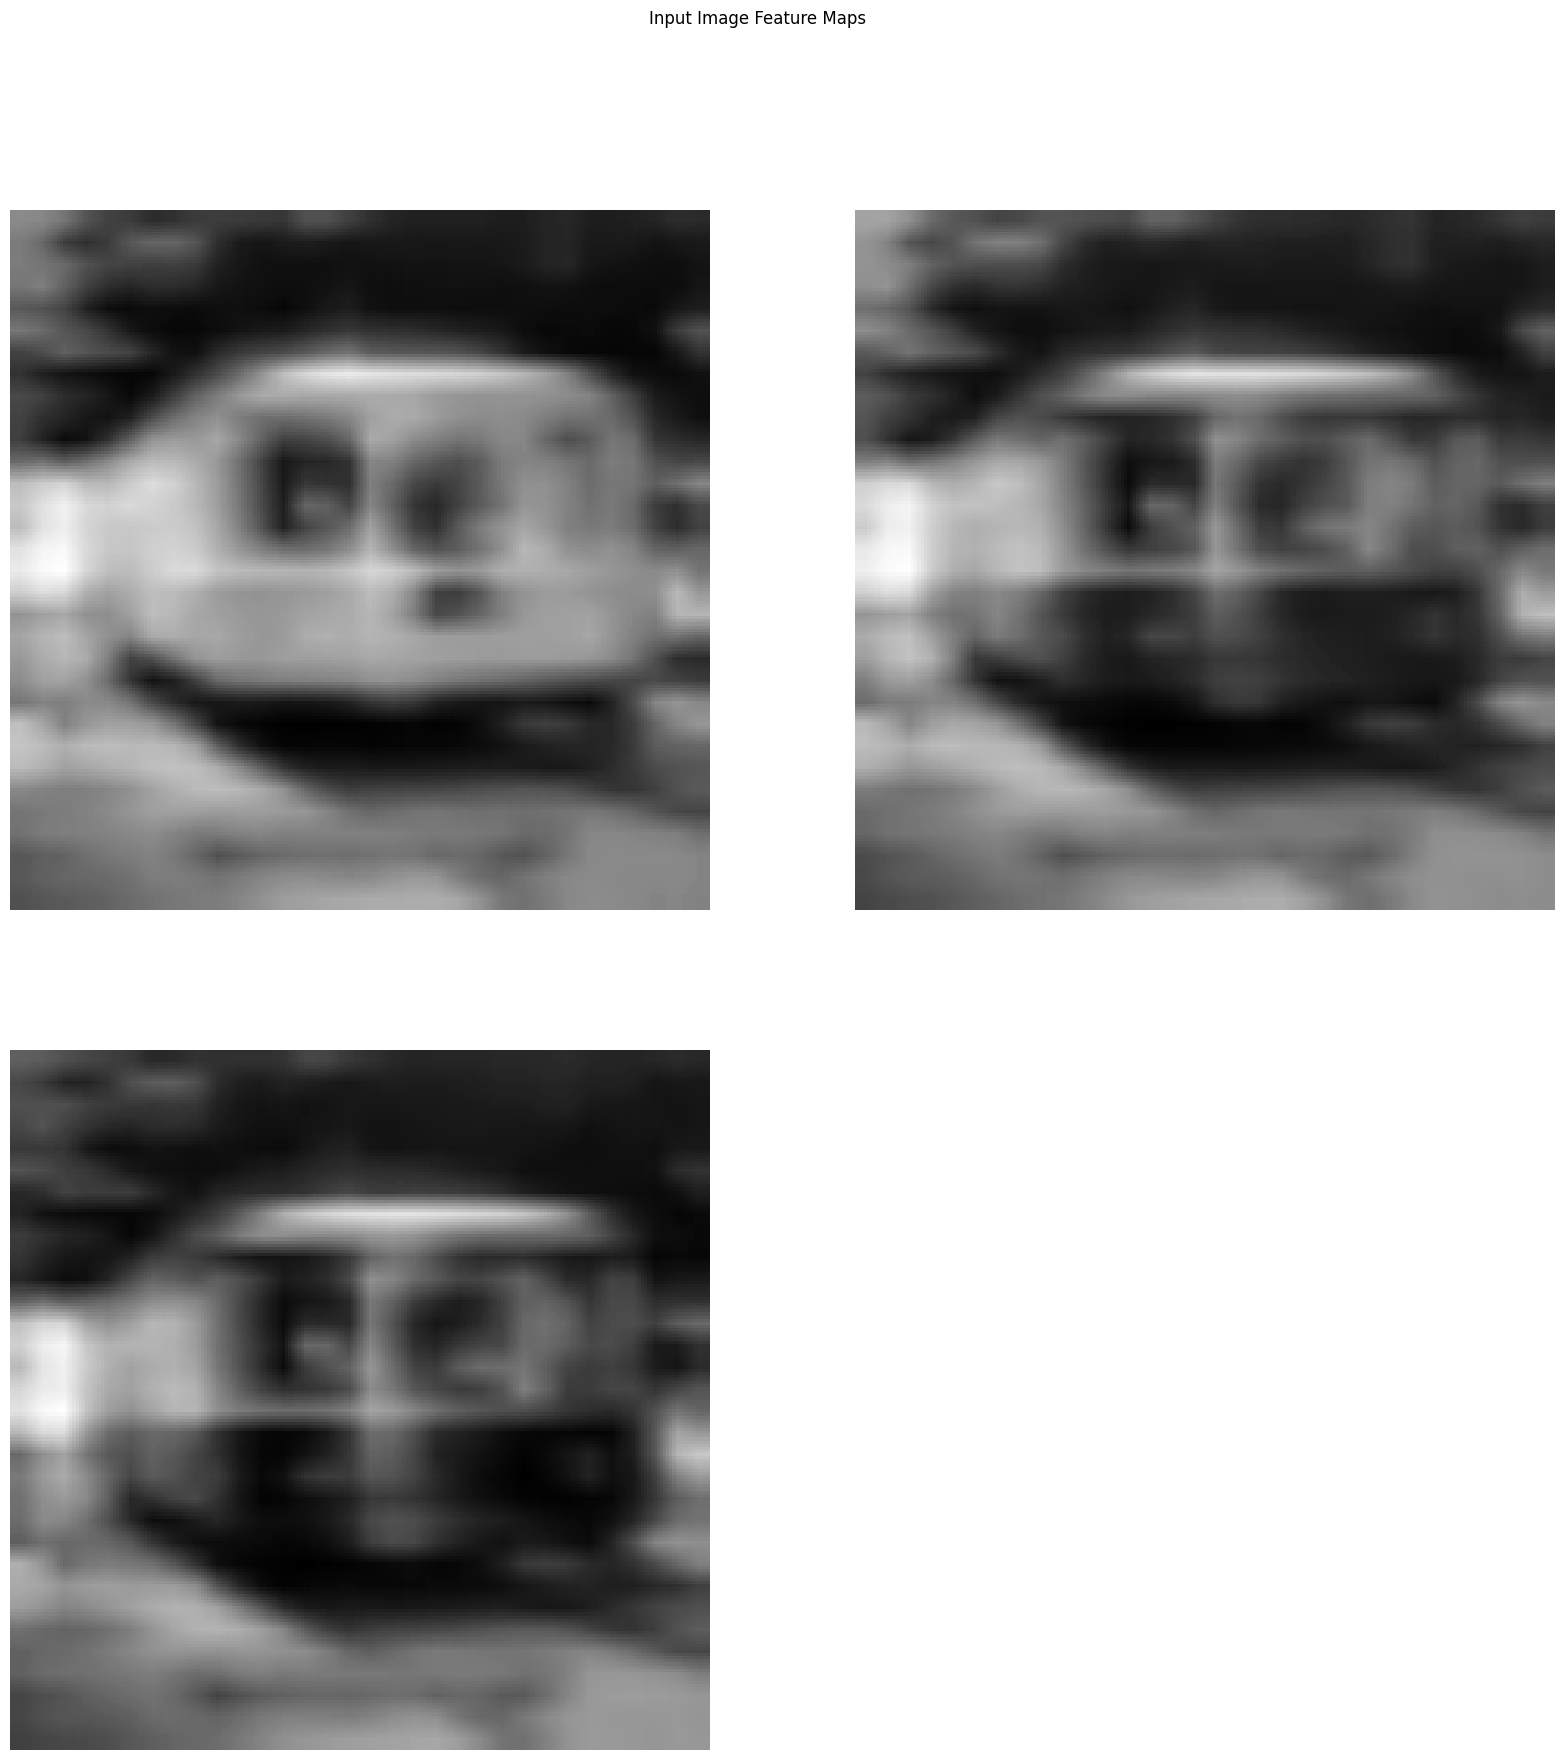

Feature Maps After Inception Module:


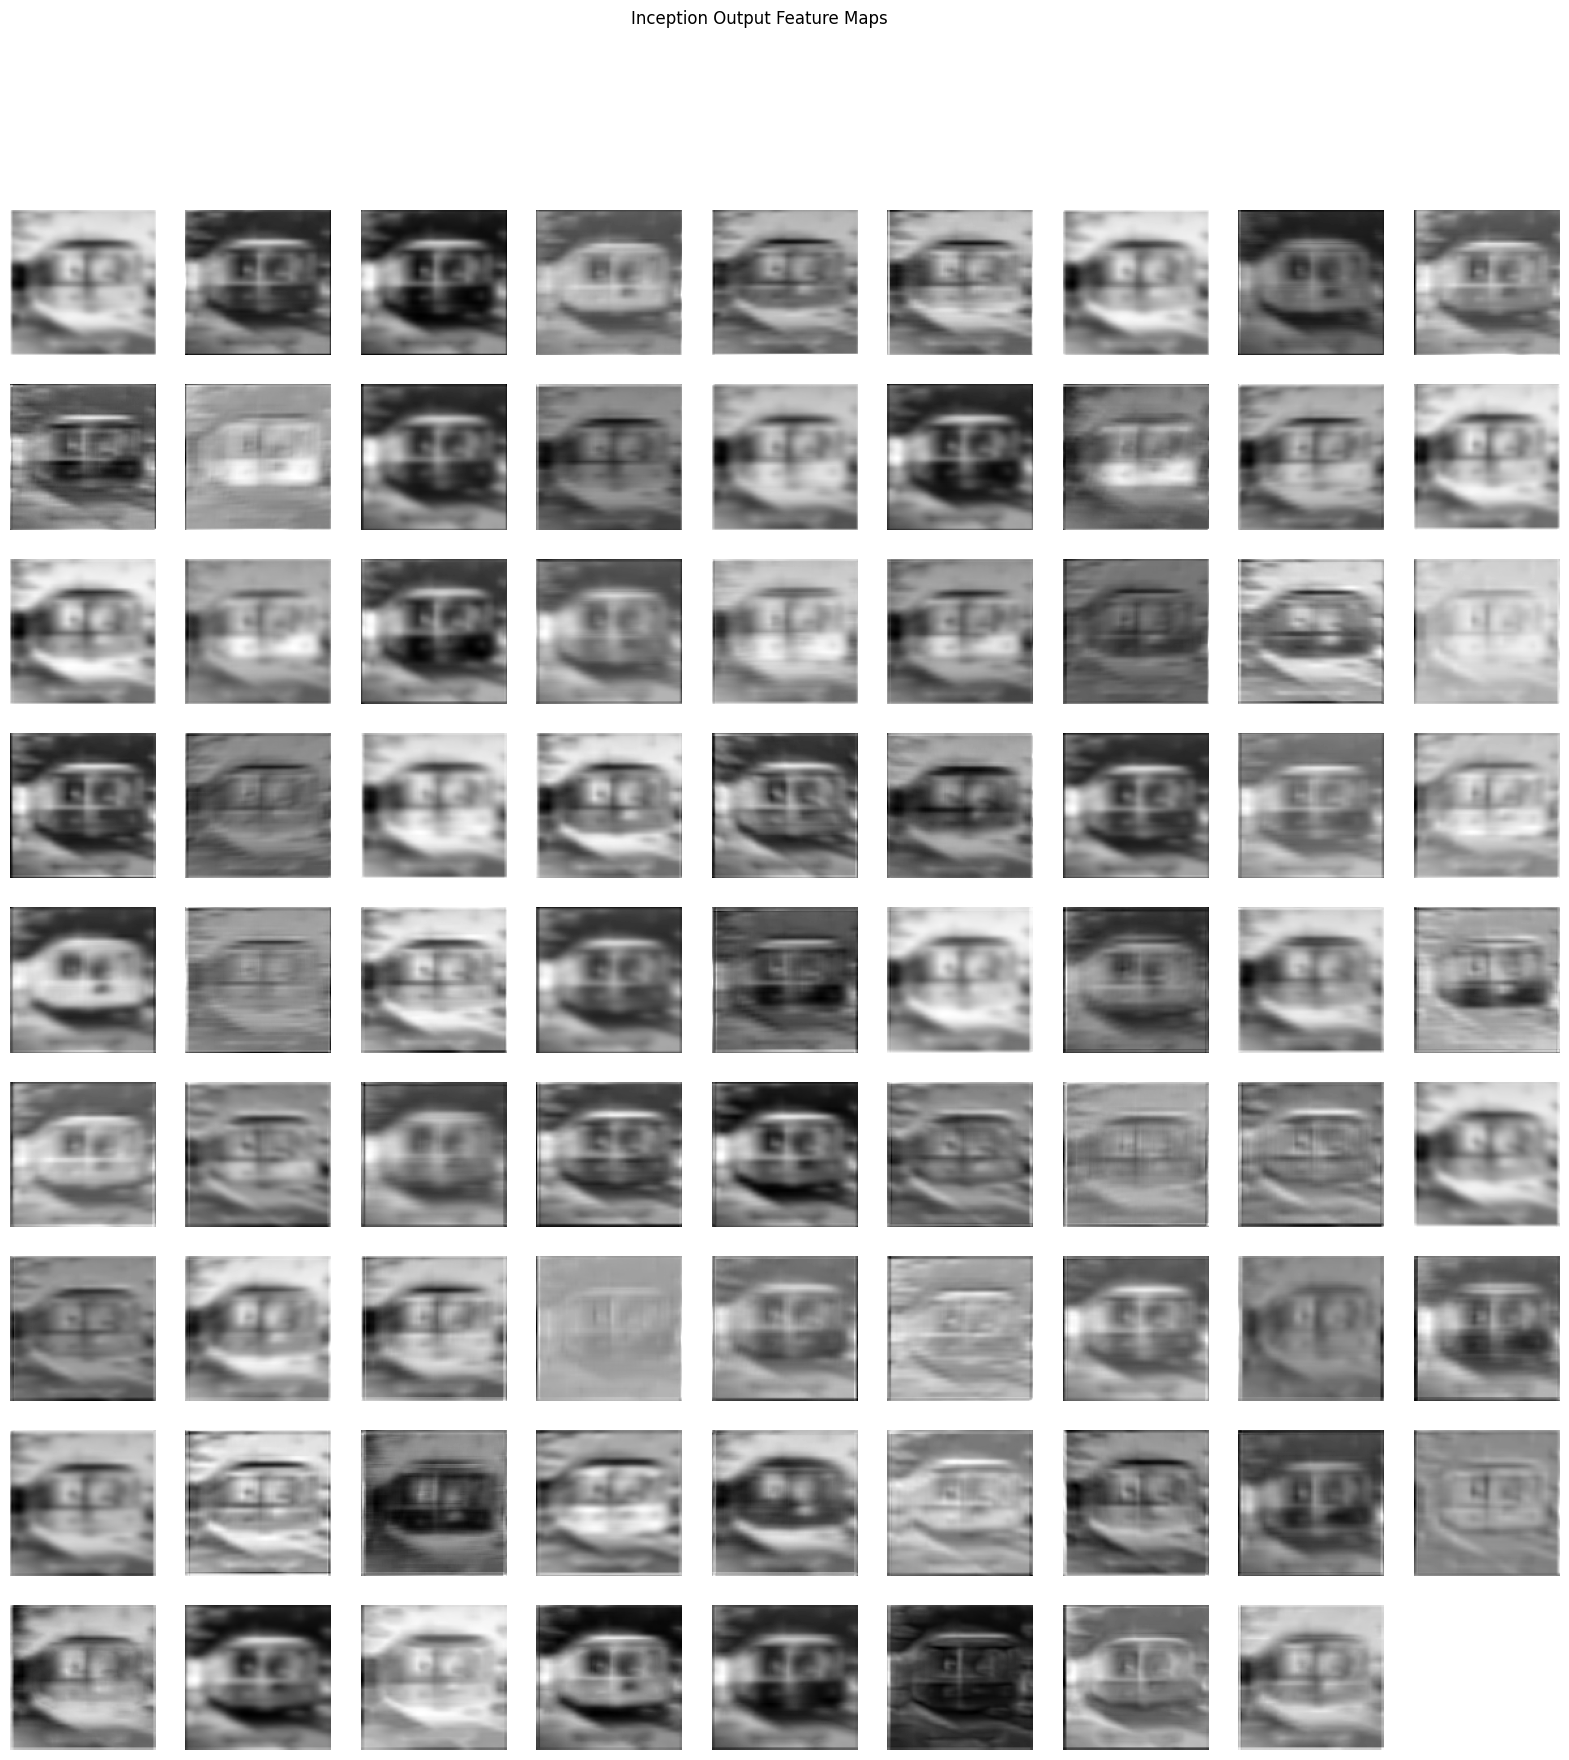

In [101]:
with torch.no_grad():
    print("Feature Maps After Initial Convolution:")
    visualize_feature_maps2(images, title="Input Image Feature Maps")

    print("Feature Maps After Inception Module:")
    visualize_feature_maps2(inception_output, title="Inception Output Feature Maps")

    # print("Auxiliary Classifier Output (Before Softmax):", aux_output)
